In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
dataset = pd.read_csv('/content/creditcard.csv')

In [3]:
dataset.info
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
X = dataset.drop('Class', axis=1)
y = dataset['Class']

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [7]:
X_train_normal = X_train[y_train == 0]
X_test_normal = X_test[y_test == 0]
X_test_anomalies = X_test[y_test == 1]

In [8]:
input_dim = X_train_normal.shape[1]

In [9]:
encoder=models.Sequential([
    layers.Input(shape=(input_dim,)),
    layers.Dense(32,activation="relu"),
    layers.Dense(16,activation="relu"),
    layers.Dense(8,activation="relu")
])

In [10]:
decoder=models.Sequential([
    layers.Input(shape=(8,)),
    layers.Dense(16,activation="relu"),
    layers.Dense(32,activation="relu"),
    layers.Dense(input_dim,activation="linear")
])

In [11]:
autoencoder = models.Sequential([encoder, decoder])
autoencoder.compile(loss="mean_squared_error", optimizer="adam")

In [12]:
autoencoder.fit(X_train_normal, X_train_normal, epochs=10, shuffle=True, batch_size=64)

Epoch 1/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step - loss: 0.6835
Epoch 2/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.4197
Epoch 3/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.3639
Epoch 4/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3345
Epoch 5/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.3195
Epoch 6/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.3022
Epoch 7/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2908
Epoch 8/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2802
Epoch 9/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step - loss: 0.2710
Epoch 10/10
3554/3554 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.2627


In [13]:
y_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - y_pred, 2), axis=1)

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 1s 684us/step


In [14]:
threshold = np.percentile(mse[y_test == 0], 95)
print("Reconstruction error threshold:", threshold)

Reconstruction error threshold: 0.7983800793907345


In [15]:
anomalies = mse > threshold
total_anomalies = np.sum(anomalies)
print("Total No. of Anomalies Detected:", total_anomalies)

Total No. of Anomalies Detected: 2927


In [16]:
print("Classification Report:")
class_report = classification_report(y_test, anomalies)
print(class_report)

print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, anomalies)
print(conf_matrix)

accuracy = accuracy_score(y_test, anomalies)
precision = precision_score(y_test, anomalies)
recall = recall_score(y_test, anomalies)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56864
           1       0.03      0.85      0.05        98

    accuracy                           0.95     56962
   macro avg       0.51      0.90      0.51     56962
weighted avg       1.00      0.95      0.97     56962

Confusion Matrix:
[[54020  2844]
 [   15    83]]
Accuracy: 0.9498
Precision: 0.0284
Recall: 0.8469


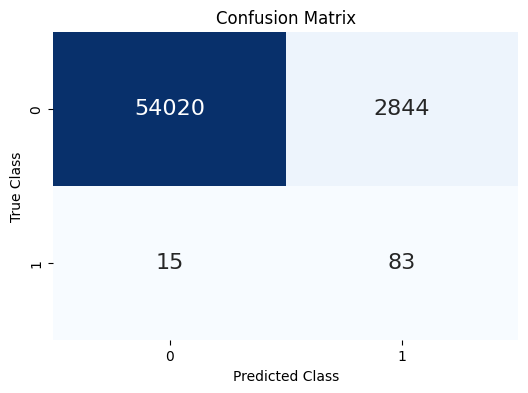

In [17]:
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 16})
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.title("Confusion Matrix")
plt.show()